In [1]:
from __future__ import print_function, division

%matplotlib notebook
import seaborn as sns
# sns.set(context="poster", font_scale=1.5)
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

from astropy.modeling import models, fitting, \
                             FittableModel, Parameter

## Boilerplate path hack to give access to full clustered_SNe package
import sys, os
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))
        

from clustered_SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   metallicity_solar
from clustered_SNe.analysis.parse import Overview, RunSummary, \
                                         Inputs
    
from clustered_SNe.analysis.database_helpers import session, \
                                                Simulation, \
                                                Simulation_Inputs, \
                                                Simulation_Status

/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/Users/egentry/Dropbox/data/clustered_SNe/analysis/../../clustered_SNe/analysis/database_helpers.py:41: UserWarning: `session' from database_helpers can only write using 1 process at a time
  UserWarning)


In [2]:
class Momentum_Surface_Point(object):
    def __init__(self, simulation):
        self.mass        = simulation.cluster_mass
        self.momentum    = simulation.momentum
        self.density     = simulation.background_density
        self.metallicity = simulation.metallicity
        self.id          = simulation.id

In [3]:
points = []

for simulation in session.query(Simulation):
    status = session.query(Simulation_Status).get(simulation.id)
    if status is None:
        continue
    if status.status == "Error":
        continue
    point = Momentum_Surface_Point(simulation)
    points.append(point)

In [4]:
points

In [5]:
metallicities = np.array([point.metallicity for point in points])
densities =     np.array([point.density     for point in points])
masses =        np.array([point.mass        for point in points])
momenta =       np.array([point.momentum    for point in points])

momenta = momenta / masses / 1e5 # [km / s]
masses = masses / M_solar # [M_solar]


metallicities_1D = np.sort(list(set(metallicities)))
densities_1D     = np.sort(list(set(densities)))
masses_1D        = np.sort(list(set(masses)))

metallicities_3D, densities_3D, masses_3D = np.meshgrid(metallicities_1D, densities_1D, masses_1D, 
                                                       indexing="ij") 

momenta_3D = np.empty_like(masses_3D)

for i, metallicity in enumerate(metallicities_1D):
    for j, density in enumerate(densities_1D):
        for k, mass in enumerate(masses_1D):

            good_metallicities = (metallicities == metallicity)
            good_densities     = (densities == density)
            good_masses        = (masses == mass)
            good = good_metallicities & good_densities & good_masses
            
            momenta_3D[i,j,k] = np.average(momenta[good])


momenta_3D[momenta_3D == 0] = 1 # in case we take the log...

In [6]:
class Momentum_Model(object):
    
    def __init__(self, 
                 norm_low,            norm_high,
                 eta_metallicity_low, eta_metallicity_high, 
                 eta_density_low,     eta_density_high, 
                 eta_mass_low,        eta_mass_high):
        
        params_0 = (norm_low,            norm_high,
                    eta_metallicity_low, eta_metallicity_high,
                    eta_density_low,     eta_density_high,
                    eta_mass_low,        eta_mass_high)
        self.params_0 = params_0
        self.params   = params_0
    
    def __call__(self, metallicity, density, mass):
        
        norm_low,            norm_high, \
        eta_metallicity_low, eta_metallicity_high, \
        eta_density_low,     eta_density_high, \
        eta_mass_low,        eta_mass_high = self.params
        
        x =(metallicity, density, mass)
        
        return self.evaluate(x,
                             np.log10(norm_low),  np.log10(norm_high),
                             eta_metallicity_low, eta_metallicity_high,
                             eta_density_low,     eta_density_high,
                             eta_mass_low,        eta_mass_high)
        
    def __str__(self):
        s  = "p/M ~ min("
        s +=       "{0:.2e}"
        s +=       " * (Z / Z_sun)**{1:.2f}"
        s +=       " * (rho / m_p)**{2:.2f}"
        s +=       " * (M/1e2 M_sun)**{3:.2f}"
        s += " , "
        s +=       "{4:.2e}"
        s +=       " * (Z / Z_sun)**{5:.2f}"
        s +=       " * (rho / m_p)**{6:.2f}"
        s +=       " * (M/1e5 M_sun)**{7:.2f}"
        s += ")"
        s = s.format(self.params[0], self.params[2], self.params[4], self.params[6],
                     self.params[1], self.params[3], self.params[5], self.params[7])
        
        return s
    def fit(self, x, y, fixed=None, **kwargs):
        """Fits the model using its initial self.params_0;
        Stores result as self.params
        

        Parameters
        --------
            x : locations of initial N data points; array: N x 3
                - metallicity 
                - density [g cm**-3]
                - mass [M_solar]
                - momentum efficiency [km / s]
            y : momentum efficiency [g cm**-3] at those N data points; array: Nx1
            fixed : mask of values to be held fixed; None or np.ndarray (dtype=bool)
                - fixed values set to True
                - free  values set to False
                - None for all values free
            **kwargs : to be passed to optimize.curve_fit; dict
                - does NOT get passed to the fitted function


        Returns
        -------
        popt : best-fit parameters; array: 8x1
        pcov : estimated parameter covariance; array: n_free x n_free
            - where: n_free = sum(~fixed)


        Side effects
        ------------
        Overwrites self.params with latest fit results
        
        Notes
        -----
        Fits self.evaluate
        
        covariance for normalizations is covariance in the *log*
        
        Doesn't return pcov entries corresponding to fixed values.
        This might cause errors if you forget to check if a parameter was fixed.
        In the future this should be fixed.
        """
        p0 = np.array(self.params_0)
        p0[0:2] = np.log10(p0[0:2])
        
        if fixed is None:
            fixed = np.full_like(p0, False, dtype=bool)
        elif isinstance(fixed, np.ndarray):
            if not fixed.dtype == bool:
                raise TypeError("fixed must be an np.ndarray of bools")
        else:
            raise TypeError("fixed must be type None or np.ndarray")
            
        def _f(x, *args):
            p0[~fixed] = args
            return self.evaluate(x, *p0)
        
        popt, pcov = optimize.curve_fit(_f, x, y, p0=p0[~fixed],
                                        xtol=.01,
                                        **kwargs)
        p0[~fixed] = popt
        popt = p0
        popt[0:2] = 10**popt[0:2] # we fit the log of the normalization
        self.params = tuple(popt)
        return popt, pcov

    
    @staticmethod
    def evaluate(x,
                log_norm_low,    log_norm_high,
                eta_metallicity_low, eta_metallicity_high,
                eta_density_low, eta_density_high,
                eta_mass_low,    eta_mass_high):
        norm_low = 10**log_norm_low
        norm_high = 10**log_norm_high
        
        metallicity, density, mass = x
        
        # Normalize p_M_low at M=10**2 M_solar
        p_M_low  = norm_low  \
                    * (metallicity / metallicity_solar)**eta_metallicity_low \
                    * (density / m_proton)**eta_density_low \
                    * (mass / (1e2 ))**eta_mass_low
        
        # Normalize p_M_low at M=10**5 M_solar
        p_M_high = norm_high \
                    * (metallicity / metallicity_solar)**eta_metallicity_high \
                    * (density / m_proton)**eta_density_high \
                    * (mass / (1e5 ))**eta_mass_high
        
        p_M = (p_M_low * p_M_high) / (p_M_low + p_M_high)
            
        return p_M

        

## Example: visualize surface (fixed metallicity)

<IPython.core.display.Javascript object>


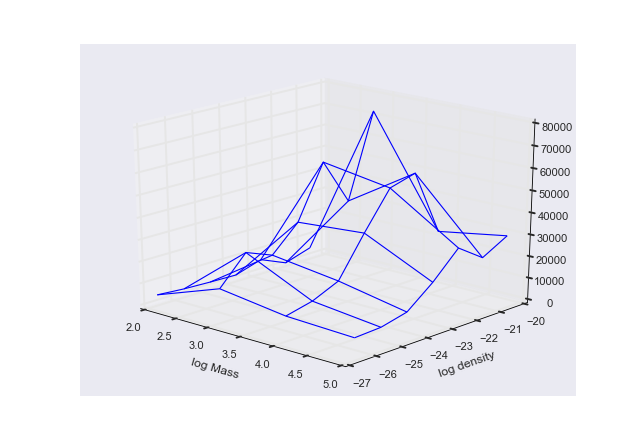

In [7]:
%matplotlib notebook

metallicity_index = np.argmax(metallicities_1D==metallicity_solar)

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with sns.plotting_context("poster"):
    surf = ax.plot_wireframe(np.log10(masses_3D[   metallicity_index,:,:]),
                             np.log10(densities_3D[metallicity_index,:,:]),
                             momenta_3D[           metallicity_index,:,:],
                             rstride=1, cstride=1, linewidth=1)

    plt.xlabel("log Mass")
    plt.ylabel("log density")
    plt.show()

## Example: visualize surface (fixed density)

<IPython.core.display.Javascript object>


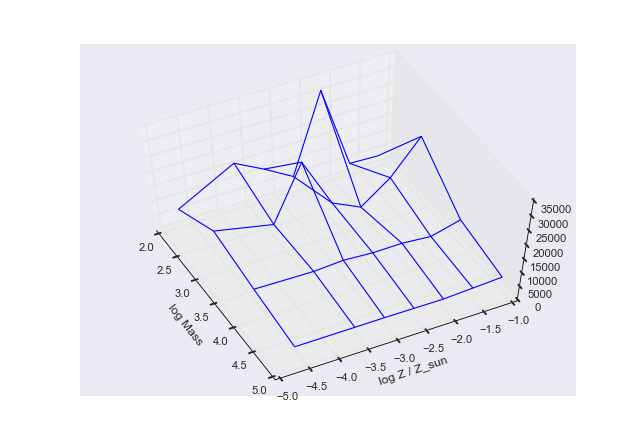

In [8]:
%matplotlib notebook

density_index = np.argmax(densities_1D==1.33 * m_proton)

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

with sns.plotting_context("poster"):
    surf = ax.plot_wireframe(np.log10(masses_3D[       :, density_index, :]),
                             np.log10(metallicities_3D[:, density_index, :]),
                             momenta_3D[               :, density_index, :],
                             rstride=1, cstride=1, linewidth=1)

    plt.xlabel("log Mass")
    plt.ylabel("log Z / Z_sun")
    plt.show()

## Test: call the model 

[   975.49663245  20076.00089131  15823.85280802   9999.900001  ]


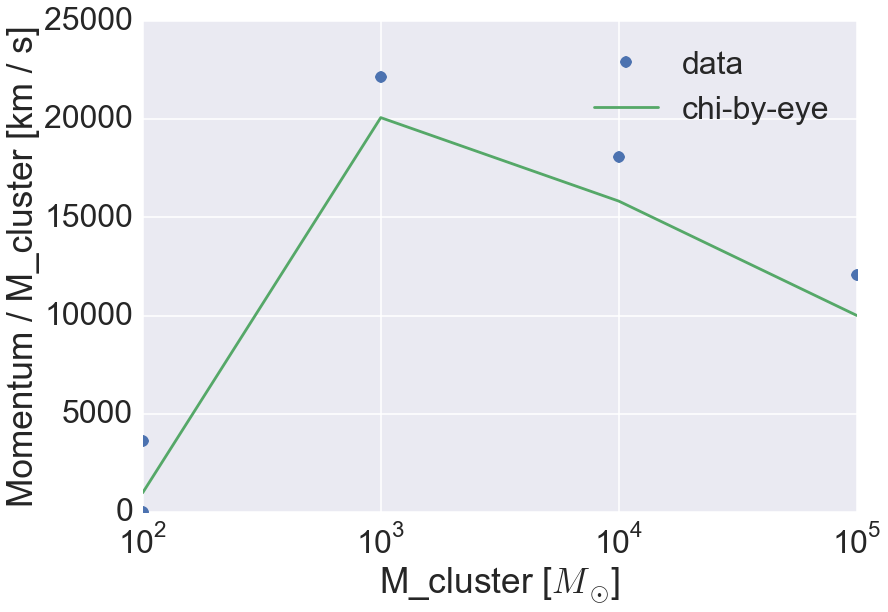

In [9]:
%matplotlib inline

metallicity_index = np.argmax(metallicities_1D==metallicity_solar)
density_index = 2

tmp_model = Momentum_Model(1e3, 1e4, 
                           0, 0, 
                           0, 0, 
                           2, -.2)

print(tmp_model(metallicities_3D[metallicity_index, density_index],
                densities_3D[    metallicity_index, density_index], 
                masses_3D[       metallicity_index, density_index]))

with sns.plotting_context("poster", font_scale=2):
    metallicity = metallicities_1D[metallicity_index]
    density     = densities_1D[density_index]
    plot_mask = np.isclose(densities, density, atol=0) & np.isclose(metallicities, metallicity, atol=0)
    plt.plot(masses[ plot_mask],
             momenta[plot_mask],
             marker= "o", linestyle="",
             label="data")
    
    plt.plot(masses_3D[metallicity_index, density_index],
             tmp_model(metallicities_3D[metallicity_index, density_index],
                       densities_3D[    metallicity_index, density_index],
                       masses_3D[       metallicity_index, density_index]),
            label="chi-by-eye")
    
    plt.xscale("log")
    plt.xlabel("M_cluster [$M_\odot$]")
    plt.ylabel("Momentum / M_cluster [km / s]")
    plt.legend(loc="best")

## Test: fit the model (using 1D slice -- fixed density, metallicity)

y_init:  [   958.17418004  14805.16541474  13165.21225579   9999.900001  ]
params_0:  (1000.0, 10000.0, 0, 0, 0, 0, 2, -0.12)
params:    (1933.4735183542261, 13105.157228563898, 0.0, 0.0, 0.0, 0.0, 2.616843035950978, -0.12)


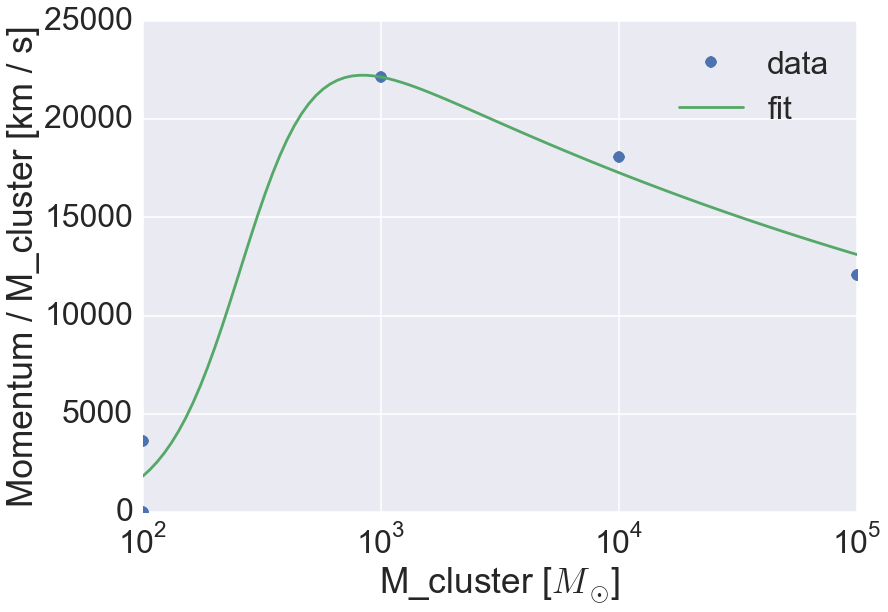

In [10]:
%matplotlib inline

metallicity_index = np.argmax(metallicities_1D==metallicity_solar)
density_index = 2

tmp_model = Momentum_Model(1e3, 1e4, 
                           0, 0, 
                           0, 0, 
                           2, -.12)
fixed = np.array([False, False, 
                  True, True, 
                  True, True, 
                  False, True])

y_init = tmp_model(metallicities_3D[metallicity_index, density_index],
                   densities_3D[    metallicity_index, density_index],
                   masses_3D[       metallicity_index, density_index])
print("y_init: ", y_init)

x = (metallicities_3D[metallicity_index, density_index], 
     densities_3D[    metallicity_index, density_index], 
     masses_3D[       metallicity_index, density_index])
y = momenta_3D[metallicity_index, density_index]
popt, pcov = tmp_model.fit(x, y, fixed=fixed)

print("params_0: ", tmp_model.params_0)
print("params:   ", tmp_model.params)

x_fit = np.logspace(2,5, num=100)
y_fit = tmp_model(metallicities_1D[metallicity_index],
                  densities_1D[    density_index],
                  x_fit)

with sns.plotting_context("poster", font_scale=2):
    metallicity = metallicities_1D[metallicity_index]
    density     = densities_1D[density_index]
    plot_mask = np.isclose(densities, density, atol=0) & np.isclose(metallicities, metallicity, atol=0)
    plt.plot(masses[ plot_mask],
             momenta[plot_mask],
             marker= "o", linestyle="",
             label="data")
    
    plt.plot(x_fit, y_fit,  label="fit")
#     plt.plot(masses_3D[metallicity_index, density_index], y_init, label="Chi-by-eye")
    plt.xscale("log")
    plt.legend(loc="best")
    plt.xlabel("M_cluster [$M_\odot$]")
    plt.ylabel("Momentum / M_cluster [km / s]")

## Test: fit the model (using 2D slice of solar metallicity)

params_0:  (1000.0, 10000.0, 0, 0, 0.25, 0.2, 2, -0.12)
params:    (234034193410845.34, 25.408940056035103, -15.061913112496827, 2.1362420193515672, -6.1307488281137941, 1.0339339054515519, 46.127942842286259, -0.12)

overall model:  p/M ~ min(2.34e+14 * (Z / Z_sun)**-15.06 * (rho / m_p)**-6.13 * (M/1e2 M_sun)**46.13 , 2.54e+01 * (Z / Z_sun)**2.14 * (rho / m_p)**1.03 * (M/1e5 M_sun)**-0.12)

metallicity:  0.02
density:      2.224587e-27
p/M ~ min(4.10e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**10.76 , 8.02e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


/Users/egentry/anaconda/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


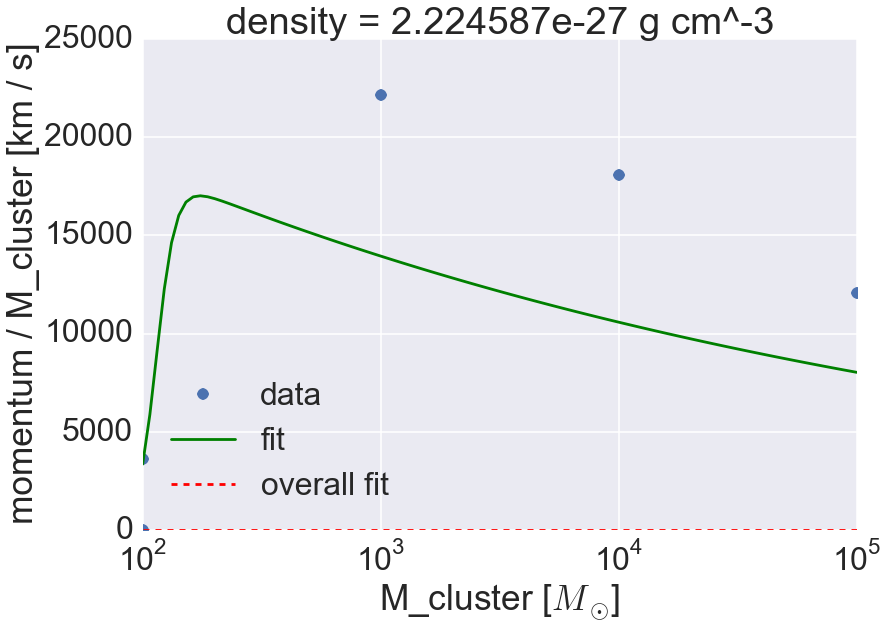


metallicity:  0.02
density:      2.224587e-26
p/M ~ min(2.55e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**14.29 , 1.27e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


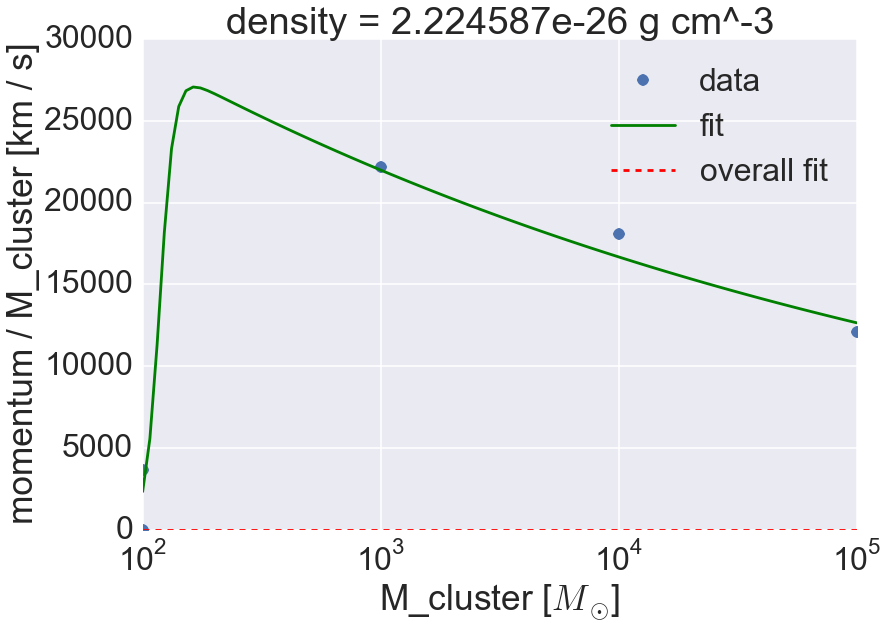


metallicity:  0.02
density:      2.224587e-25
p/M ~ min(1.93e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**2.62 , 1.31e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


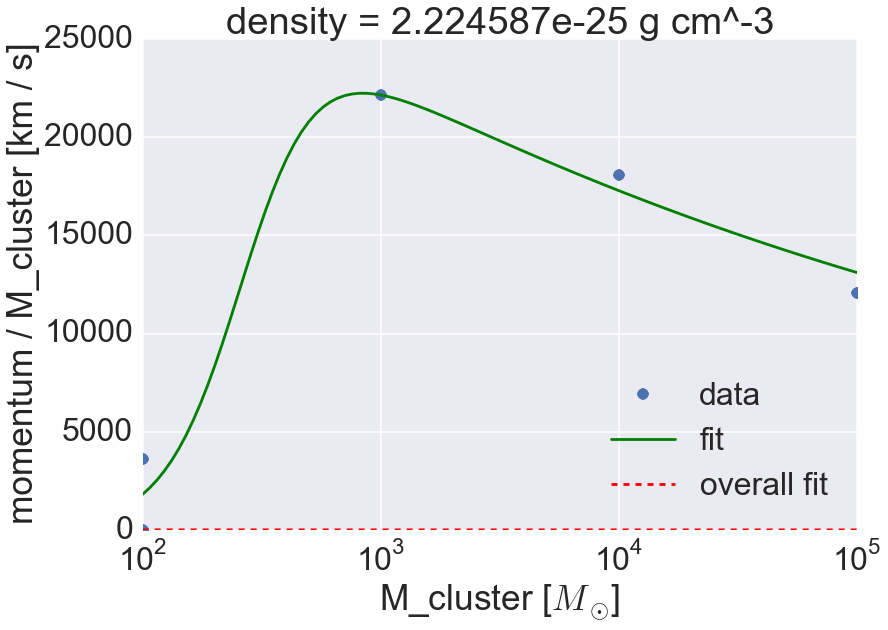


metallicity:  0.02
density:      2.224587e-24
p/M ~ min(1.33e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**2.04 , 2.53e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


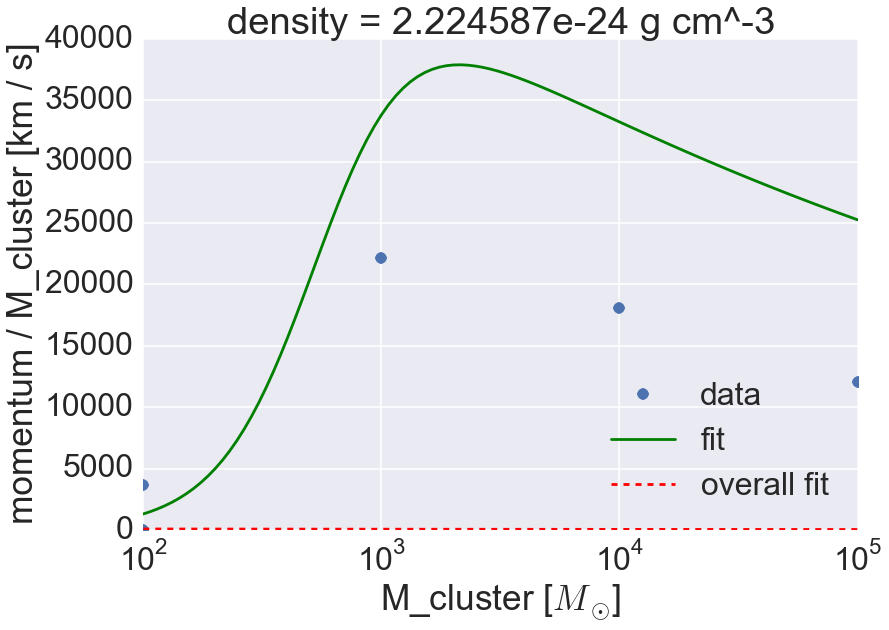


metallicity:  0.02
density:      2.224587e-23
p/M ~ min(5.77e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**3.15 , 3.35e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


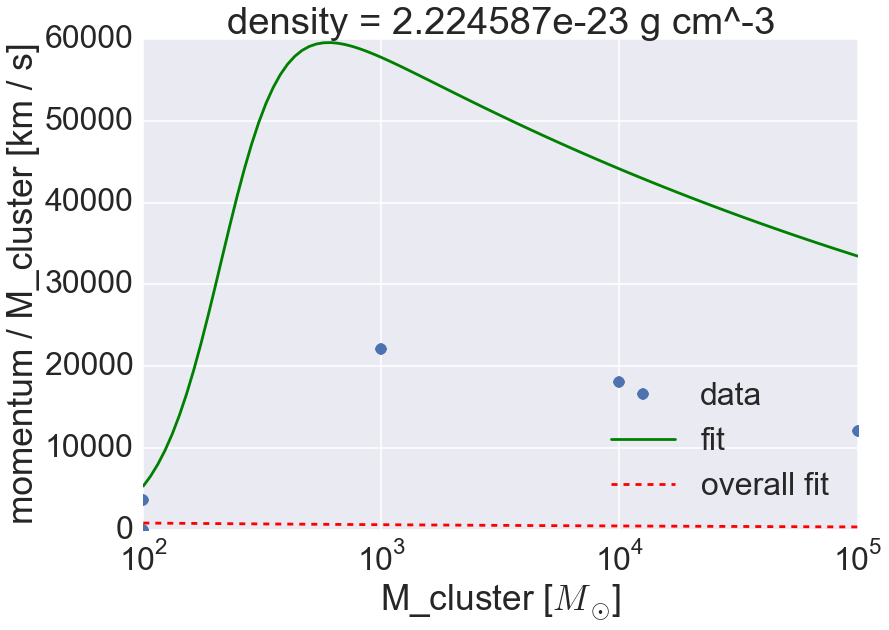


metallicity:  0.02
density:      2.224587e-22
p/M ~ min(6.96e-05 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**9.10 , 3.64e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


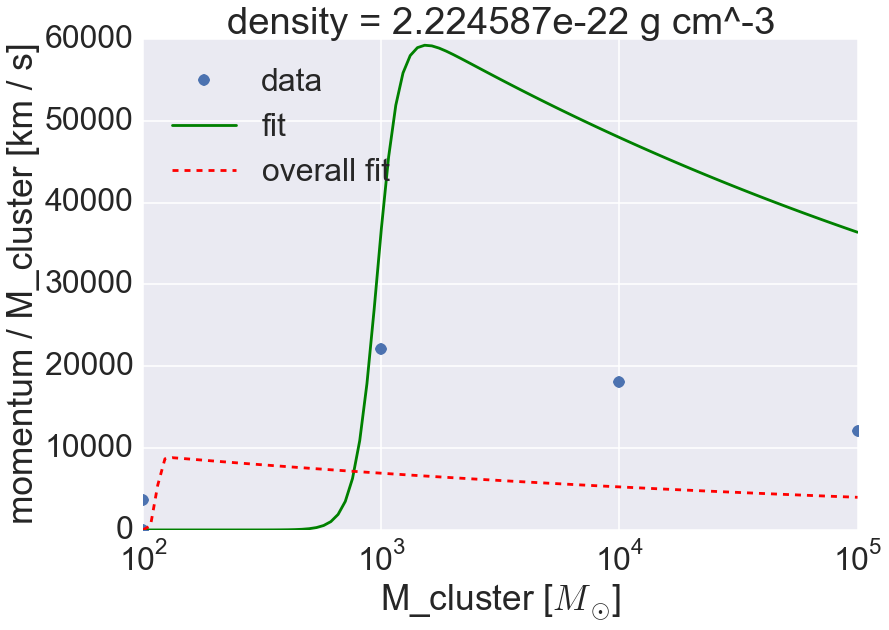


metallicity:  0.02
density:      2.224587e-21
p/M ~ min(4.00e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**23.72 , 3.42e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


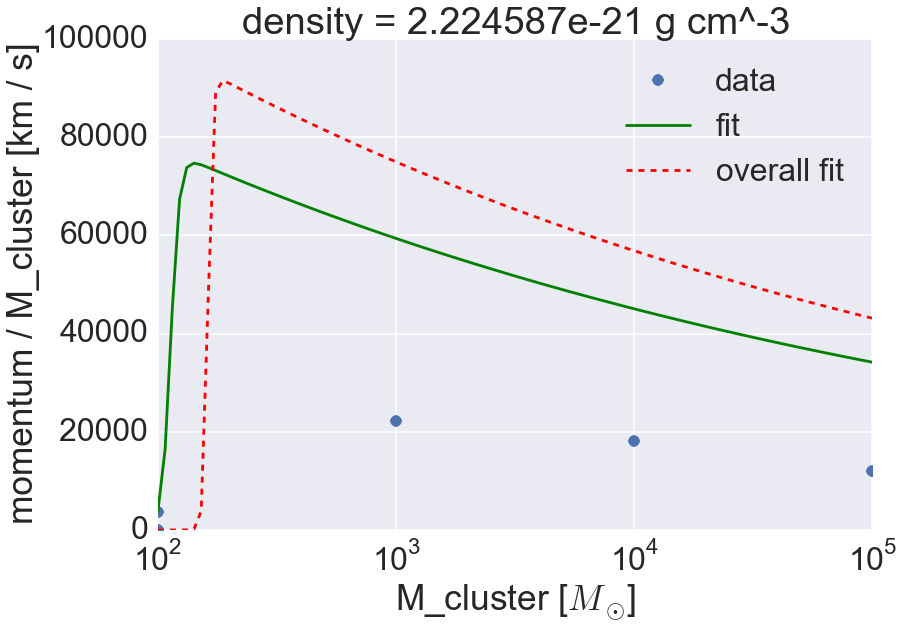

In [11]:
%matplotlib inline

metallicity_index = np.argmax(metallicities_1D==metallicity_solar)
density_index = 2

model_overall = Momentum_Model(1e3, 1e4,
                               0, 0, 
                               .25, .2,
                               2, -.12)
fixed = np.array([False, False, 
                  False, False, 
                  False, False, 
                  False, True])


xs = [metallicities_3D.flatten(),
      densities_3D.flatten(),
      masses_3D.flatten()]
ys = momenta_3D.flatten()
mask = np.isfinite(xs[0]) & np.isfinite(xs[1]) & np.isfinite(xs[2]) & np.isfinite(ys)
xs[0] = xs[0][mask]
xs[1] = xs[1][mask]
xs[2] = xs[2][mask]

ys = ys[mask]

popt, pcov = model_overall.fit(xs, ys, fixed=fixed)
print("params_0: ", model_overall.params_0)
print("params:   ", model_overall.params)
print()
print("overall model: ", str(model_overall))

models = []

with sns.plotting_context("poster", font_scale=2):
    for density_index_tmp in range(7):
        model_tmp = Momentum_Model(1e3, 1e4, 
                                   0, 0, 
                                   0, 0,
                                   2, -.12)
        fixed = np.array([False, False, 
                          True, True, 
                          True, True, 
                          False, True])
        
        x = [metallicities_3D[metallicity_index, density_index_tmp],
             densities_3D[    metallicity_index, density_index_tmp],
             masses_3D[       metallicity_index, density_index_tmp]]
        y = momenta_3D[metallicity_index, density_index_tmp]
        
        mask = np.isfinite(x[0]) & np.isfinite(x[1]) & np.isfinite(x[2]) & np.isfinite(y)

        x[0] = x[0][mask]
        x[1] = x[1][mask]
        x[2] = x[2][mask]
        y = y[mask]
        fitted = False
        if len(x[0]) >= (~fixed).sum():
            model_tmp.fit(x,y, fixed=fixed)
            fitted = True
        models.append(model_tmp)
        
        x_fit = np.logspace(2,5, num=100)
        y_fit = model_tmp(metallicities_1D[metallicity_index],
                          densities_1D[    density_index_tmp],
                          x_fit)
        y_fit_overall = model_overall(metallicities_1D[metallicity_index],
                                      densities_1D[    density_index_tmp],
                                      x_fit)
        print()
        print("=================")
        print("metallicity: ", metallicities_1D[metallicity_index])
        print("density:     ", densities_1D[    density_index_tmp])
        print(str(model_tmp))
        plt.figure()
        plt.title("density = {0:e} g cm^-3".format(densities_1D[density_index_tmp]))


        metallicity = metallicities_1D[metallicity_index]
        density     = densities_1D[density_index]
        plot_mask = np.isclose(densities, density, atol=0) & np.isclose(metallicities, metallicity, atol=0)
        plt.plot(masses[ plot_mask],
                 momenta[plot_mask],
                 marker= "o", linestyle="",
                 label="data")
        if fitted:
            plt.plot(x_fit, y_fit,  label="fit", color="g")
        plt.plot(x_fit, y_fit_overall, label="overall fit", linestyle="--", color='r')
        plt.xscale("log")
        plt.legend(loc="best")
        plt.xlabel("M_cluster [$M_\odot$]")
        plt.ylabel("momentum / M_cluster [km / s]")
        plt.show()
        

## Test: fit the model (using 2D slice -- fixed density)

params_0:  (1000.0, 10000.0, 0, 0, 0.25, 0.2, 2, -0.12)
params:    (234034193410845.34, 25.408940056035103, -15.061913112496827, 2.1362420193515672, -6.1307488281137941, 1.0339339054515519, 46.127942842286259, -0.12)

overall model:  p/M ~ min(2.34e+14 * (Z / Z_sun)**-15.06 * (rho / m_p)**-6.13 * (M/1e2 M_sun)**46.13 , 2.54e+01 * (Z / Z_sun)**2.14 * (rho / m_p)**1.03 * (M/1e5 M_sun)**-0.12)

metallicity:  2e-05
density:      2.224587e-23
p/M ~ min(5.28e+02 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**1.04 , 2.15e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


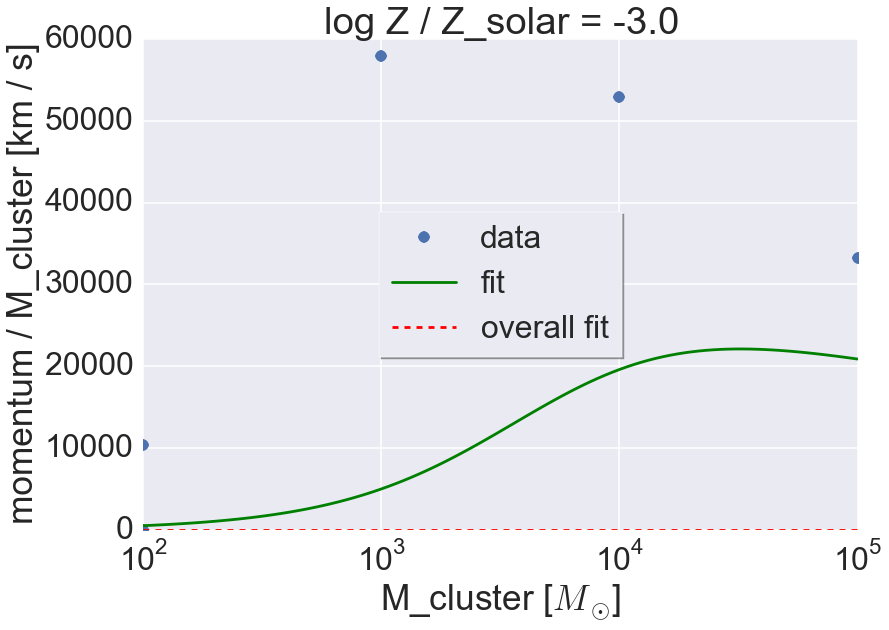


metallicity:  0.0002
density:      2.224587e-23
p/M ~ min(6.02e+02 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**1.05 , 2.20e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


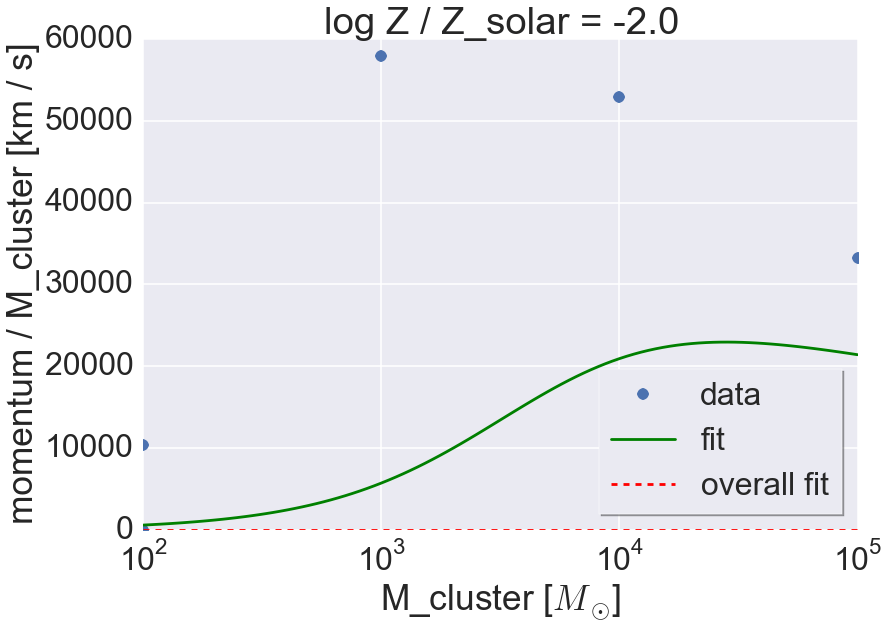


metallicity:  0.0006324555
density:      2.224587e-23
p/M ~ min(1.48e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**0.89 , 2.04e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


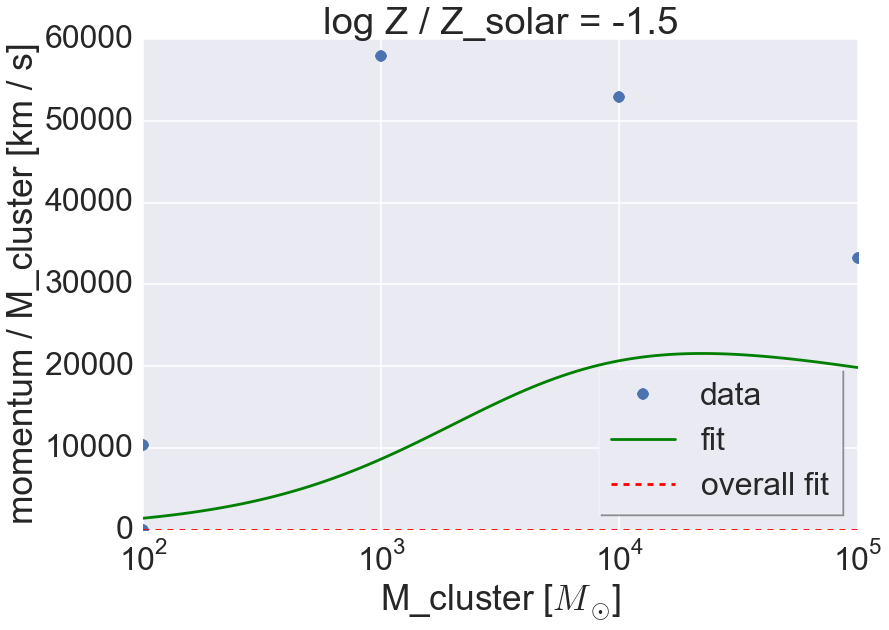


metallicity:  0.002
density:      2.224587e-23
p/M ~ min(4.18e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**0.34 , 2.55e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


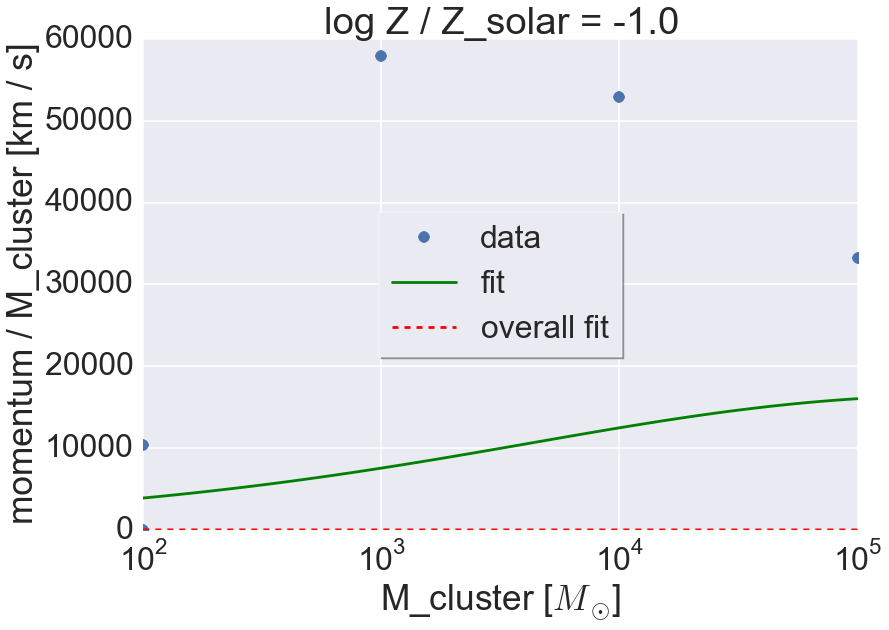


metallicity:  0.006324555
density:      2.224587e-23
p/M ~ min(1.52e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**12.97 , 3.42e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


/Users/egentry/anaconda/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


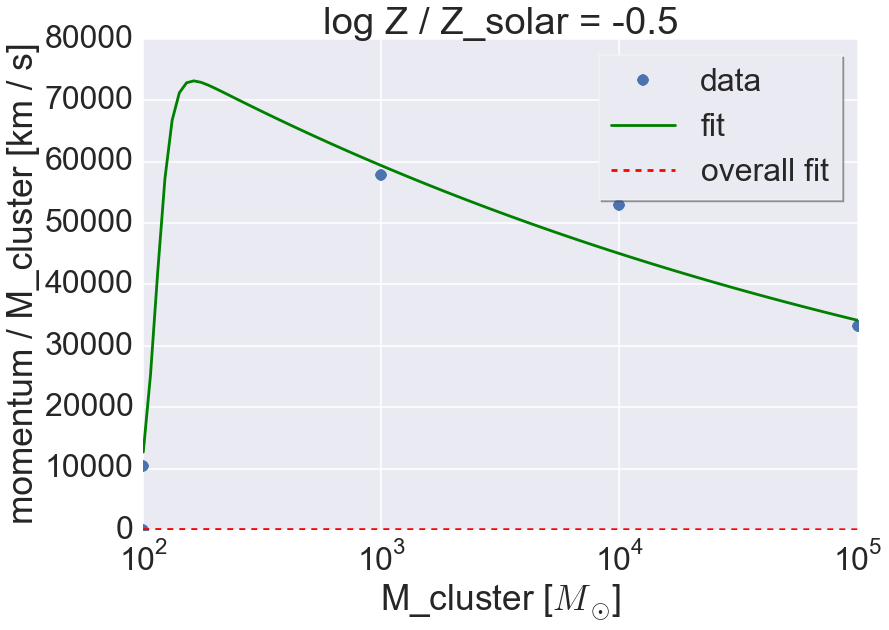


metallicity:  0.02
density:      2.224587e-23
p/M ~ min(5.77e+03 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**3.15 , 3.35e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


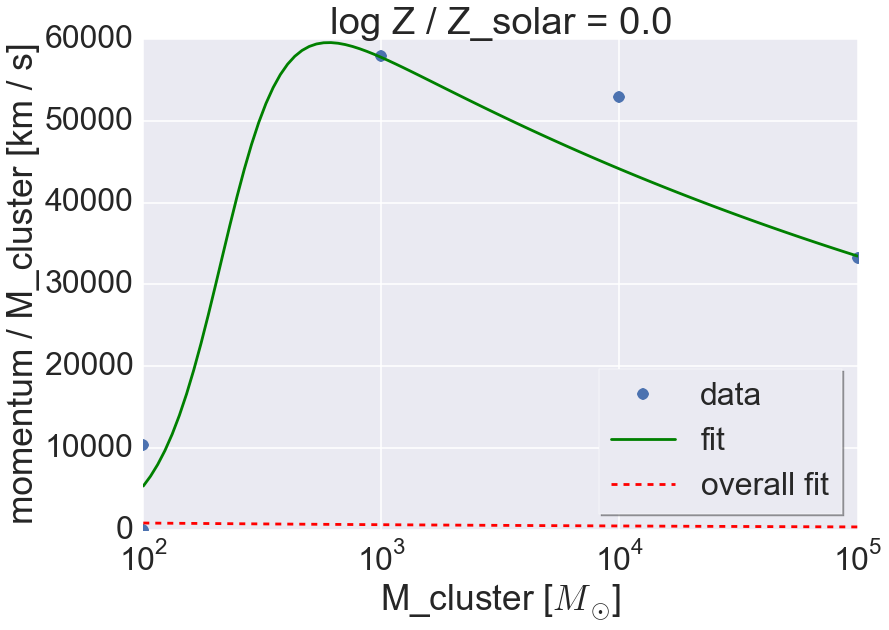


metallicity:  0.06324555
density:      2.224587e-23
p/M ~ min(3.97e+01 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e2 M_sun)**25.60 , 2.97e+04 * (Z / Z_sun)**0.00 * (rho / m_p)**0.00 * (M/1e5 M_sun)**-0.12)


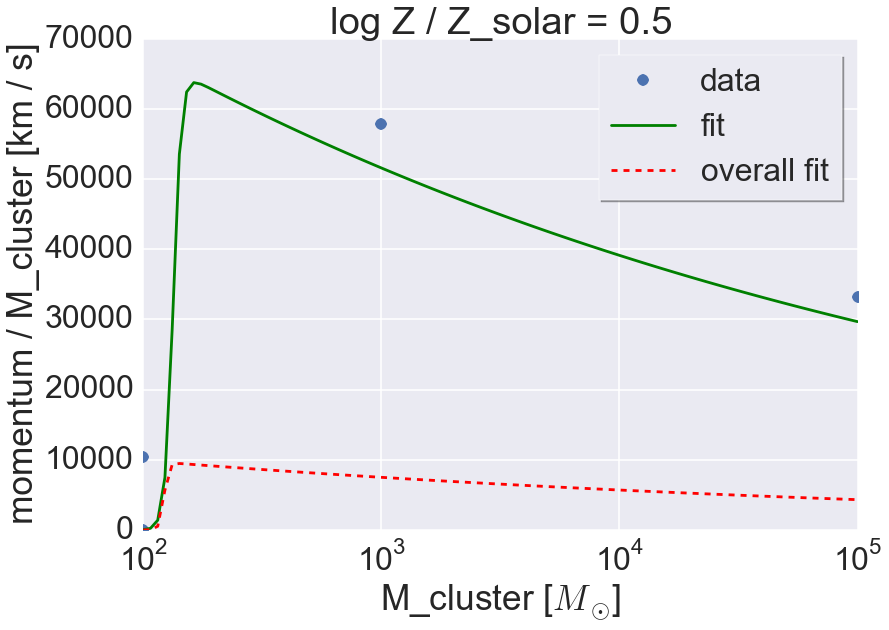

In [12]:
%matplotlib inline

density_index = np.argmax(np.isclose(densities_1D, 1.33e1 * m_proton, atol=0, rtol=1e-4))

model_overall = Momentum_Model(1e3, 1e4,
                               0, 0, 
                               .25, .2,
                               2, -.12)
fixed = np.array([False, False, 
                  False, False, 
                  False, False, 
                  False, True])


xs = [metallicities_3D.flatten(),
      densities_3D.flatten(),
      masses_3D.flatten()]
ys = momenta_3D.flatten()
mask = np.isfinite(xs[0]) & np.isfinite(xs[1]) & np.isfinite(xs[2]) & np.isfinite(ys)
xs[0] = xs[0][mask]
xs[1] = xs[1][mask]
xs[2] = xs[2][mask]

ys = ys[mask]

popt, pcov = model_overall.fit(xs, ys, fixed=fixed)
print("params_0: ", model_overall.params_0)
print("params:   ", model_overall.params)
print()
print("overall model: ", str(model_overall))

models = []

with sns.plotting_context("poster", font_scale=2):
    for metallicity_index_tmp in range(7):
        model_tmp = Momentum_Model(1e3, 1e4, 
                                   0, 0, 
                                   0, 0,
                                   2, -.12)
        fixed = np.array([False, False, 
                          True, True, 
                          True, True, 
                          False, True])
        
        x = [metallicities_3D[metallicity_index_tmp, density_index],
             densities_3D[    metallicity_index_tmp, density_index],
             masses_3D[       metallicity_index_tmp, density_index]]
        y = momenta_3D[       metallicity_index_tmp, density_index]
        
        mask = np.isfinite(x[0]) & np.isfinite(x[1]) & np.isfinite(x[2]) & np.isfinite(y)

        x[0] = x[0][mask]
        x[1] = x[1][mask]
        x[2] = x[2][mask]
        y = y[mask]
        
        fitted = False
        if len(x[0]) >= (~fixed).sum():
            fitted = True
            model_tmp.fit(x,y, fixed=fixed)
        models.append(model_tmp)
        
        x_fit = np.logspace(2,5, num=100)
        y_fit = model_tmp(metallicities_1D[metallicity_index_tmp],
                          densities_1D[    density_index],
                          x_fit)
        y_fit_overall = model_overall(metallicities_1D[metallicity_index_tmp],
                                      densities_1D[    density_index],
                                      x_fit)
        print()
        print("=================")
        print("metallicity: ", metallicities_1D[metallicity_index_tmp])
        print("density:     ", densities_1D[    density_index])
        print(str(model_tmp))
        plt.figure()
        plt.title("log Z / Z_solar = {0:.1f}".format(np.log10(metallicities_1D[metallicity_index_tmp]\
                                                               / metallicity_solar)))

        metallicity = metallicities_1D[metallicity_index]
        density     = densities_1D[density_index]
        plot_mask = np.isclose(densities, density, atol=0) & np.isclose(metallicities, metallicity, atol=0)
        plt.plot(masses[ plot_mask],
                 momenta[plot_mask],
                 marker= "o", linestyle="",
                 label="data")
        
        if fitted:
            plt.plot(x_fit, y_fit,  label="fit", color="g")
        plt.plot(x_fit, y_fit_overall, label="overall fit", linestyle="--", color="r")
        plt.xscale("log")
        plt.legend(loc="best", frameon=True, shadow=True)
        plt.xlabel("M_cluster [$M_\odot$]")
        plt.ylabel("momentum / M_cluster [km / s]")
        plt.show()